# Tight-binding toolset
## Define lattices and interface with both KITE and NonLinearInterpolation

This notebook contains the whole implementation of the library. To convert this notebook to the library, run

jupyter-nbconvert --to script interface.ipynb

In [9]:
# to convert to script run
if __name__== "__main__":
    !jupyter-nbconvert --to script band_structure.ipynb

[NbConvertApp] Converting notebook band_structure.ipynb to script
[NbConvertApp] Writing 24874 bytes to band_structure.py


In [1]:
import numpy as np
import sys
import os
import matplotlib.pyplot as plt

# Band structure class

In [2]:
class band_structure():
    
    bonds = []
    Nk = 0
    N_orbs = 0
    bonds_are_set = False
    primitive_are_set = False
    
    printable_basedir = ""
    
    dimd = 0 # Spatial dimension (is the problem 2D or 3D?)
    
    DEBUG = 0
        
    def set_primitive2(self, a1, a2):
        """2D: Set the primitive vectors of the lattice a1 and a2. This method automatically computes 
        the reciprocal lattice primitive vectors b1 and b2 such that np.dot(bn, am) = 2 pi delta_nm.
        """
        self.dimd = 2
        
        self.a1 = a1
        self.a2 = a2
        
        # Each column of A is a primitive vector
        self.A = np.zeros([2,2])
        self.A[:,0] = self.a1
        self.A[:,1] = self.a2
        

        self.B = np.linalg.inv(self.A)*np.pi*2
        self.b1 = self.B[0]
        self.b2 = self.B[1]

        self.primitive_are_set = True

    def set_primitive3(self, a1, a2, a3):
        """3D: Set the primitive vectors of the lattice a1, a2 and a3. This method automatically computes 
        the reciprocal lattice primitive vectors b1, b2 and b3 such that np.dot(bn, am) = 2 pi delta_nm.
        """
        self.dimd = 3
        
        self.a1 = a1
        self.a2 = a2
        self.a3 = a3
        
        # Each column of A is a primitive vector
        self.A = np.zeros([3,3])
        self.A[:,0] = self.a1
        self.A[:,1] = self.a2
        self.A[:,2] = self.a3
        

        self.B = np.linalg.inv(self.A)*np.pi*2
        self.b1 = self.B[0]
        self.b2 = self.B[1]
        self.b3 = self.B[2]

        self.primitive_are_set = True
        
    def set_orbs(self, orb_list, orb_pos):
        """ These positions are expressed in terms of the primitive vectors of the lattice"""
        
        self.orbitals = orb_list[:]
        self.orb_pos = orb_pos[:]
        self.N_orbs = len(orb_list)
    
    def set_bonds(self, bond_list):
        """Set the list of all hopping integrals that characterizes the 
        tight-binding model. This method expects a list of items such as the 
        following item:
        
        [ [1,0] , 'A' , 'B' , 0.1]
        
        which should be interpreted as such: if initially I'm in the 'A' orbital of the unit cell [0,0],
        then after being acted upon with the Hamiltonian, I'll be in the 'B' orbital of the unit
        cell [1,0], and my original value will have been multiplied by 0.1. The set of these items 
        should not contain the Hermitian part, because it is computed automatically."""
        
        
        self.bonds = bond_list[:]

        hermitian_bonds = []
        if(self.dimd == 2):
            for bond in self.bonds:
                origin = bond[1]
                destin = bond[2]
                relative = bond[0]
                hop = bond[3]
                if origin == destin and relative == [0,0]:
                    None
                    
                else:   
                    hermitian_bonds.append([ [-relative[0], -relative[1]], destin, origin, np.conj(hop)])
                
        elif(self.dimd == 3):
            for bond in self.bonds:
                origin = bond[1]
                destin = bond[2]
                relative = bond[0]
                hop = bond[3]
                if origin == destin and relative == [0,0,0]:
                    None
                    
                else:                
                    hermitian_bonds.append([ [-relative[0], -relative[1], -relative[2]], destin, origin, np.conj(hop)])

        else:
            print("Is the dimension 'dim' set?")
            sys.exit(1)

            
        self.bonds += hermitian_bonds

        self.bonds_are_set = True
        
        
        
        

    def set_model(self, model):
        if(model.dimd == 2):
            self.set_primitive2(model.a1, model.a2)
        elif(model.dimd == 3):
            self.set_primitive3(model.a1, model.a2, model.a3)
        self.set_orbs(model.orbitals.copy(), model.orb_pos.copy())

        self.set_bonds(model.bonds)
        self.specific_k = model.k
        


# Auxiliary container class
class model():
    None


## Functionality to calculate the band structure and the Hamiltonian in k-space

These functions can still be simplified a bit using the decomposition of the Hamiltonian into bonds


A general single-particle tight-binding Hamiltonian can be written in the following way:

$$H=\sum_{\boldsymbol{R}}\sum_{ij}t_{ij}\left(\boldsymbol{R}+\boldsymbol{d}_{ij},\boldsymbol{R}\right)\left|\boldsymbol{R}+\boldsymbol{d}_{ij},\alpha_{ij}\right\rangle \left\langle \boldsymbol{R},\alpha_{i}\right|$$

Basis in momentum space

$$ \left|\boldsymbol{p},\alpha_{i}\right\rangle =\frac{1}{\sqrt{N}}\sum_{\boldsymbol{R}}e^{i\boldsymbol{p}\cdot\left(\boldsymbol{R}+\boldsymbol{\delta}_{i}\right)}\left|\boldsymbol{R},\alpha_{i}\right\rangle  $$ 

split the Hamiltonian into its bonds

$$ \left\langle \boldsymbol{p},\alpha_{final}\right|\hat{H}_{n}\left(\mathbf{p}\right)\left|\boldsymbol{p},\alpha_{init}\right\rangle = e^{i\boldsymbol{p}\cdot\left(\boldsymbol{\delta}_{init}^{n}-\boldsymbol{\delta}_{final}^{n}-\boldsymbol{d}_{n}\right)}\left\langle \boldsymbol{d}_{n},\alpha_{final}\right|\hat{H}_{n}\left|\boldsymbol{0},\alpha_{init}\right\rangle  $$

In [3]:
def get_Hk(self, k):
    """Compute the Hamiltonian in Fourier space at wave-vector k from the list of bonds
    that was previously fed to this class. This method assumes that all the real-space
    coordinates are in the basis of the primitive vectors a1,a2 and that all the reciprocal-space
    quantities such as the wave-vector k are in the basis b1,b2. The scalar product in the
    functions of this method already has the 2pi factor included"""
    assert(self.bonds_are_set)

    H = np.matrix(np.zeros([self.N_orbs, self.N_orbs], dtype = 'complex'))

    for i in range(self.N_orbs):
        for j in range(self.N_orbs):
            H[i,j] = 0

            for bond in self.bonds:


                if bond[1] == self.orbitals[i] and bond[2] == self.orbitals[j]:
                    r = np.array(bond[0])
                    hop = bond[3]
                    orb_phase1 = np.exp(-1j*2*np.pi*np.dot(k,self.orb_pos[i]))
                    orb_phase2 = np.exp( 1j*2*np.pi*np.dot(k,self.orb_pos[j]))

                    H[i,j] += np.exp(1j*2*np.pi*np.dot(r, k))*hop*orb_phase1*orb_phase2

    return H




def set_kpath(self, k_list, num_k):
    """ Defines a path in the momentum space where the band structure
    is going to be represented. """

    num_points = len(k_list)
    self.Nk = num_k*(num_points - 1)
    self.ks = np.zeros([self.Nk, self.dimd])


    total_k = 0
    line = np.zeros([num_k, self.dimd])

    for i in range(num_points - 1):
        start = np.array(k_list[i])
        end   = np.array(k_list[i+1])
        diff  = end - start

        for j in range(num_k):
            line[j] = start + diff*j/(num_k - 1)

        self.ks[total_k:total_k + num_k] = line

        total_k += num_k
        



def get_bands(self):
    """  For each k defined in the k-path (previously defined in the set_kpath method)
    diagonalize H(k) and put the eigen energies in a list """

    assert(self.bonds_are_set)
    assert(self.Nk != 0)
    
    bands = np.zeros([self.Nk, self.N_orbs])
    H = np.zeros([self.N_orbs, self.N_orbs], dtype = 'complex')


    for k in range(self.Nk):
        H = self.get_Hk(self.ks[k])

        v = np.linalg.eigvalsh(H)
        v.sort()
        bands[k] = v


    return bands


# Add to the class
band_structure.set_kpath = set_kpath
band_structure.get_Hk = get_Hk
band_structure.get_bands = get_bands

## Print to Cpp file

This was used for the interface with JVL's and Roboredo's code on nonlinear optics

In [4]:
def printable_Hk(self):
    """Calculates the Fourier transform of the bond Hamiltonians symbolically and their 
    derivatives with respect to kx and ky"""
    
    assert(self.bonds_are_set)
    
    nder = 5 # number of derivatives
    put = "std::complex<double>({0},{1})*exp(std::complex<double>(0,{2}*k(0) + {3}*k(1)))"
    
    H = {}
    for bond in self.bonds:
#         print(bond)
        
        rel = np.array(bond[0])
        ind_orig = self.orbitals.index(bond[1])
        ind_dest = self.orbitals.index(bond[2])
        
        
        pos_orig = self.orb_pos[ind_orig]
        pos_dest = self.orb_pos[ind_dest]
        
        a = (self.orb_pos[ind_dest][0] - self.orb_pos[ind_orig][0] + rel[0])*2*np.pi
        b = (self.orb_pos[ind_dest][1] - self.orb_pos[ind_orig][1] + rel[1])*2*np.pi
        
        # numbers required for the derivatives
        idx = (a*self.a1[0] + b*self.a2[0])*1j/np.pi/2.0
        idy = (a*self.a1[1] + b*self.a2[1])*1j/np.pi/2.0
        
 
        
        for i in range(nder):
            for j in range(nder):
                val = idx**i * idy**j * bond[3]
                put_replace = put.format(val.real, val.imag,a,b)
                
                st = "{0},{1},{2},{3}".format(ind_orig, ind_dest, i,j)
                if st not in H.keys():
                    H[st] = [put_replace]
                else:
                    H[st].append(put_replace)
    
    return H




def generate_potential_file(self):
    """Generates the source code files inside the folder 'Data' """
    H = self.printable() # Hamiltonian and derivatives
    nder = 5
    
    # Make sure that the base folder is specified
    assert(self.printable_basedir != "")
    
    # Check if folder exists. If it doesn't, create it
    if not os.path.exists(self.printable_basedir + "Data"):
        os.mkdir(self.printable_basedir + "Data")
        
    for i in range(nder):
        for j in range(nder):
            filename = self.printable_basedir+"Data/potential-{0}-{1}.txt".format(i,j)
            
            
            # Find all the keys that correspond to this potential-i-j
            lista = []
            for key in H.keys():
                o1,o2,d1,d2 = key.split(",")
                if int(d1) == i and int(d2) == j:
                    lista.append(key)

            
            matrix = [["0.0" for ii in range(self.N_orbs)] for jj in range(self.N_orbs)]
            for li in lista:
                st = ""
                terms = H[li]
                NT = len(terms)
                
                
                if NT == 1:
                    st = terms[0]
                elif NT > 1:
                    st = terms[0]
                    for k in range(1,NT):
                        st += "+" + terms[k]
                else:
                    print("This shouldn't run... How did you get here?")
                
                o1, o2 = li.split(",")[:2]
                matrix[int(o1)][int(o2)] = st
            
            
            # Create the final string
            st = "A << "
            for ii in range(self.N_orbs):
                for jj in range(self.N_orbs):
                    if ii == self.N_orbs - 1 and jj == self.N_orbs - 1:
                        st += matrix[ii][jj] + ";"
                    else:
                        st += matrix[ii][jj] + ","
                st += "\n"
                
            
            if(self.DEBUG > 0):
                print(filename)
                print(st)
            
            
            f = open(filename, 'w')
            f.write(st)
            f.close()
            
            
def generate_lattice_file(self):
    """ Generate a file with the lattice properties. This function writes the 
    primitive vectors and the reciprocal lattice primitive vectors to the file 
    'Lattice.hpp'  """
    
    # Make sure that the base folder is specified
    assert(self.printable_basedir != "")
    filename = self.printable_basedir + "Lattice.hpp"
    
    st = ""
    
    if self.dimd == 2:
        st  = "a << {0},{1},\n{2},{3};\n".format(self.a1[0], self.a1[1], self.a2[0], self.a2[1])
        st += "b << {0},{1},\n{2},{3};\n".format(self.b1[0], self.b1[1], self.b2[0], self.b2[1])
        
    else:
        print("other dimensions not implemented yet")
    
    f = open(filename, 'w')
    f.write(st)
    f.close()
    
    
    
def generate_properties_file(self):
    """ Generate a file 'Properties.hpp' with the general properties such 
    as the spatial dimension and the number of bands that the model has. """
    
    # Make sure that the base folder is specified
    assert(self.printable_basedir != "")
    
    
    filename = self.printable_basedir+"Properties.hpp"
    st = "#define Dim {0}\n#define NBANDS {1}\n".format(self.dimd, self.N_orbs)
    
    f = open(filename, 'w')
    f.write(st)
    f.close()
    

# Add functions to the class
band_structure.printable = printable_Hk
band_structure.generate_potential_file  = generate_potential_file
band_structure.generate_lattice_file    = generate_lattice_file
band_structure.generate_properties_file = generate_properties_file

## Self-energy functionality

In [5]:
def get_spectral_linearized(filename):
    data = np.loadtxt(filename)
    energies = data[:,0]
    NE, ncols = data.shape

    dim = int(ncols//3)


    green = np.zeros([dim, NE], dtype='complex')


    for i in range(dim):
        green[i,:] = data[:,i*3 + 1] + 1j*data[:,i*3 + 2]

    return energies, green


def get_spectral(filename):
    """Gets the spectral function G(k,E) from a file. This matrix is the disorder-averaged
    Green's function for a specific wave-vector k and a set of energies. In the data file, it
    should be stored as


    E1   Re[G_00(E1)] Im[G_00(E1)]  E1   Re[G_01(E1)] Im[G_01(E1)] ...
    E2   Re[G_00(E2)] Im[G_00(E2)]  E1   Re[G_01(E2)] Im[G_01(E2)] ...
    .
    .
    .
    EM   Re[G_00(EM)] Im[G_00(EM)]  EM   Re[G_01(EM)] Im[G_01(EM)] ...



    where EM is the M-th value of energy in a list of M energies, G_ij(EM) is the ij-th
    matrix element of the Green's function computed at energy EM and wave-vector k, which is
    the same for the whole file. N is the number of orbitals in the model (which is also the
    number of bands), so it should be 1 for the simple square lattice, 2 for simple graphene,
    4 for graphene with spin, etc.

    This method stores the Green's function as a matrix with 3 indices, where the first two
    are the row and column and the third is the energy, so


               |  G_00(E)  G_01(E)  ...  G_0N(E) |
               |  G_10(E)  G_11(E)  ...  G_1N(E) |
    G(:,:,E) = |                     .           |
               |                     .           |
               |  G_N0(E)  G_N1(E)  ...  G_NN(E) |

    """


    data = np.loadtxt(filename)
    energies = data[:,0]
    NE, ncols = data.shape

    dim = int(np.sqrt(ncols//3 + 0.0001))


    green = np.zeros([NE,dim*dim], dtype='complex')


    for i in range(dim*dim):
        green[:,i] = data[:,i*3 + 1] + 1j*data[:,i*3 + 2]

    green_matrix = np.zeros([dim,dim,NE], dtype = 'complex')
    for i in range(dim):
        for j in range(dim):
            green_matrix[i,j,:] = green[:,j + dim*i]

    return energies, green_matrix


def self_energy(Hk,energies, green_matrix):

    self_en = green_matrix.copy()*0
    inv_G   = green_matrix.copy()*0
    dim = self_en.shape[0]
    #print("self-energy: dim", dim)
    NE = len(energies)
    for e in range(NE):
        g = green_matrix[:,:,e]
        inv = np.linalg.inv(g*dim)

        # Hk is divided by dim because KITE normalizes the k vector
        # to the whole Hilbert space, while I normalize to the
        # number of unit cells
        # self_en[:,:,e] = inv - energies[e]*np.eye(dim)
        self_en[:,:,e] = inv + Hk - energies[e]*np.eye(dim)
        # self_en[:,:,e] = inv + Hk.transpose() - energies[e]*np.eye(dim)
        inv_G[:,:,e] = inv
    return self_en, inv_G


def save(filename, energies, se):

    dim, temp, NE = se.shape
    se_lin = np.zeros([NE, 2*dim*dim+1])
    se_lin[:,0] = energies

    for i in range(dim*dim):
        se_lin[:,2*i + 1] = np.real(se[i%dim, i//dim,:])
        se_lin[:,2*i + 2] = np.imag(se[i%dim, i//dim,:])
    np.savetxt(filename, se_lin)

    
def process(self, in_file, out_file):
    hh = self.get_Hk(self.specific_k)
    energies, green_matrix = get_spectral(in_file)
    se,grg = self_energy(hh, energies, green_matrix)
    save(out_file, energies, se)

    return energies, se
    
band_structure.process = process

# Premade tight-binding models

## Graphene

### Regular graphene hoppings and global shift

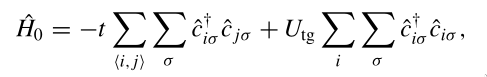

In [ ]:
# Graphene hoppings
def graphene(t):
    hops = []
    for A, B in zip(["Au", "Ad"], ["Bu","Bd"]):
        hops.append([B, A, 0, 0, t])
        hops.append([B, A, 1, 0, t])
        hops.append([B, A, 1,-1, t])
    return hops

# Global shift
def global_shift(Utg):
    hops = []
    for orb in orbs:
        hops.append([orb, orb, 0,0, Utg])
    return hops
    

### Sublattice distinction

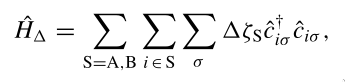

In [ ]:
# sublattice distinction
def sublattice_dist(Δ):
    hops = []
    orbsp = ["Au", "Ad", "Bu", "Bd"]
    for orb, sign in zip(orbsp, [ 1, 1,-1,-1]):
        hops.append([orb, orb, 0,0, Δ*sign])
    return hops

### Kane-Mele

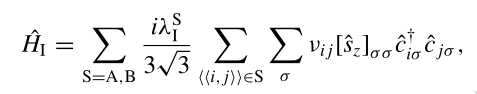
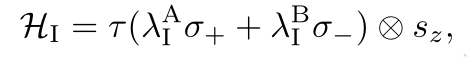

In [ ]:
# Kane-Mele
def KaneMele(λIA, λIB):
    KMA = 1j*λIA/3/np.sqrt(3)
    KMB = 1j*λIB/3/np.sqrt(3)
    
    hops = []
    for orb, sign in zip(["Au", "Ad"], [1,-1]):
        hops.append([orb, orb, 1, 0,-KMA*sign])
        hops.append([orb, orb, 0, 1, KMA*sign])
        hops.append([orb, orb,-1, 1,-KMA*sign])

    for orb, sign in zip(["Bu", "Bd"], [1,-1]):
        hops.append([orb, orb, 1, 0, KMB*sign])
        hops.append([orb, orb, 0, 1,-KMB*sign])
        hops.append([orb, orb,-1, 1, KMB*sign])
        
    return hops

### Rashba with twist angle

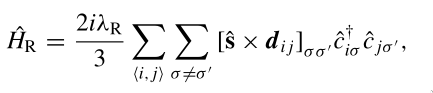
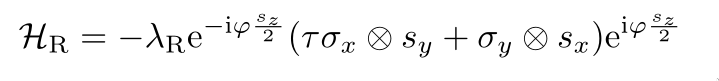

In [ ]:
# Rashba hoppings with phase
def rashba_phase(λR, φ):
    R  = λR*2j/3
    sq = np.sqrt(3)/2
    z  = np.exp( 1j*φ)
    zc = z.conjugate()
    
    hops = []
    hops.append(["Au", "Bd", 0, 0,             1j*R*z ])
    hops.append(["Ad", "Bu", 0, 0,            -1j*R*zc])
    hops.append(["Au", "Bd",-1, 1, ( 0.5 + 1j*sq)*R*z ])
    hops.append(["Ad", "Bu",-1, 1, ( 0.5 - 1j*sq)*R*zc])
    hops.append(["Au", "Bd",-1, 0, (-0.5 + 1j*sq)*R*z ])
    hops.append(["Ad", "Bu",-1, 0, (-0.5 - 1j*sq)*R*zc])
    
    return hops

### Magnetization and exchange

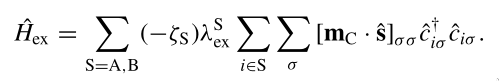

In [1]:
# Magnetization along z
def magnetization(mag):
    hops = []
    orbsp = ["Au", "Ad", "Bu", "Bd"]
    for orb, sign in zip(orbsp, [ 1,-1, 1,-1]):
        hops.append([orb, orb, 0,0, mag*sign])
    return hops


# Exchange with m along z
def exchange(mag):
    hops = []
    orbsp = ["Au", "Ad", "Bu", "Bd"]
    for orb, sign in zip(orbsp, [ 1,-1,-1,1]):
        hops.append([orb, orb, 0,0, mag*(-sign)])
    return hops

## Branislav: Kubo vs Keldysh

Hamiltonian used for the Kubo vs Keldysh paper
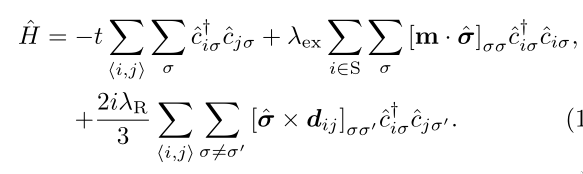

In [ ]:
def KuboVsKeldysh():
    
    # All the energy scales are in units of the graphene hopping
    t   = -1.0  # [t] Graphene hoppings 
    λex =  0.4  # [t] Magnetization
    λR  =  0.3  # [t] Rashba coupling
    φ   =  0.0  # [t] Rashba phase
    
    hops = []
    hops += graphene(t)
    hops += rashba_phase(λR, φ)
    hops += magnetization(λex)
    
    return hops

## Jaroslav

The Hamiltonian is defined in its linearized version in Jaroslav's paper:

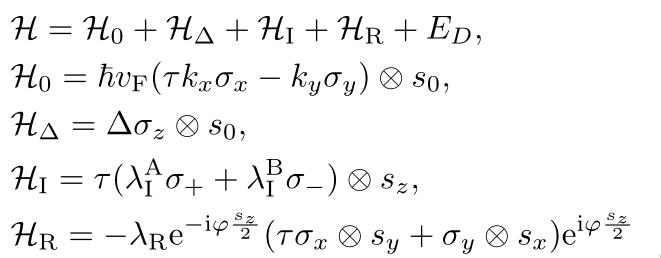

But a closely-related real-space version is available in another paper (https://journals.aps.org/prresearch/abstract/10.1103/PhysRevResearch.2.043057)

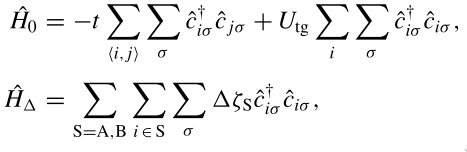
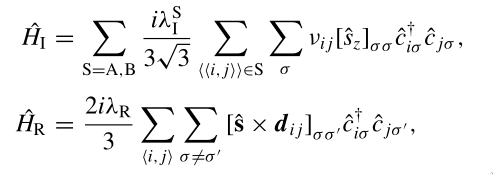

The only difference to keep in mind is the additional phase in the Rashba coupling. <br>
A more detailed explanation of the terms can be found in a paper by Denis Kochan: https://journals.aps.org/prb/abstract/10.1103/PhysRevB.95.165415

In [6]:
def Jaroslav(t,Δ,λIA,λIB,λR,φ):
    
    # t   = -2.7  # [eV] Graphene hoppings
    # Δ   =  0.0  # [eV] sublattice distinction
    # λIA =  0.01 # [eV] Kane-Mele A sublattice
    # λIB =  0.02 # [eV] Kane-Mele B sublattice
    # λR  =  0.3  # [eV] Rashba coupling
    # φ   =  1.2  # [eV] Rashba phase
    
    hops = []
    hops += graphene(t)
    hops += sublattice_dist(Δ)
    hops += KaneMele(λIA, λIB)
    hops += rashba_phase(λR, φ)
    
    return hops

# Example

In [6]:
if __name__ == "__main__":
    print("Running example")
    
    GR = band_structure()
    GR.DEBUG = 0 # Debug flag. Set to 1 to get debug information

    # Lattice properties and primitive vectors (already defined reciprocal lattice vectors)
    acc = 1.0
    a = np.sqrt(3)
    a1 = np.array([1.0,  0.0           ])*a
    a2 = np.array([0.5,  np.sqrt(3)/2.0])*a
    GR.set_primitive2(a1,a2)
    
    
    # Information about the orbitals
    orbitals = ["A", "B", "C"]
    orb_pos = [np.array([0.0    ,  0.0    ]), 
               np.array([0.0    ,  0.0    ]),
               np.array([1.0/3.0, -2.0/3.0])] # in units of the primitive lattice vectors
    GR.set_orbs(orbitals, orb_pos)

    
    # Information about the hoppings for the tight-binding model
    bonds = []
    t = 1.0

    bonds.append([[ 0, 0], 'A', 'B', -0.7*t])
    bonds.append([[-1, 1], 'A', 'B', -2.0*t])
    bonds.append([[ 0, 1], 'A', 'B',  0.4*t])
    bonds.append([[-1, 1], 'A', 'C', -1.1*t])
    bonds.append([[-1, 0], 'B', 'C',  0.3*t])
    GR.set_bonds(bonds)
    
    
    # Write the data into the NonLinearOpticsInterpolation 'Models' folders
    # so that it can be compiled into a program
    GR.printable_basedir = "/home/simao/projects_sync/codes/NonLinearOpticsInterpolation/Src/Models/"
    GR.generate_potential_file()
    GR.generate_lattice_file()   
    GR.generate_properties_file()


Running example


FileNotFoundError: [Errno 2] No such file or directory: '/home/simao/projects_sync/codes/NonLinearOpticsInterpolation/Src/Models/Data'

# Plot the band structure along a path

In [ ]:

if __name__ == "__main__":   
    G = [0,0]
    M = [0.5, 0]
    K = [1.0/3.0, -1.0/3.0]

    GR.set_kpath([G,K,M,G],100)

    fig, axs = plt.subplots()
    bands = GR.get_bands()

    for i in range(GR.N_orbs):
        b = bands[:,i]
        axs.plot(b,c='b')


    plt.show()

# Example 2

In [ ]:
if __name__ == "__main__":
    print("Running example")
    
    GR = bs.band_structure()
    GR.DEBUG = 0 # Debug flag. Set to 1 to get debug information

    # Lattice properties and primitive vectors (already defined reciprocal lattice vectors)
    acc = 1.0
    a = np.sqrt(3)
    a1 = np.array([1.0,  0.0           ])*a
    a2 = np.array([0.5,  np.sqrt(3)/2.0])*a
    GR.set_primitive2(a1,a2)
    
    
    # Information about the orbitals
    orbitals = ["A", "B"]
    orb_pos = [np.array([0.0    ,  0.0    ]), 
               np.array([1.0/3.0, -2.0/3.0])] # in units of the primitive lattice vectors
    GR.set_orbs(orbitals, orb_pos)

    
    # Information about the hoppings for the tight-binding model
    bonds = []
    t = 2.33*0+1
    gap = 7.8*0
    bonds.append([[ 0, 0], 'A', 'B', -t])
    bonds.append([[-1, 1], 'A', 'B', -t])
    bonds.append([[ 0, 1], 'A', 'B', -t])
    bonds.append([[ 0, 0], 'A', 'A',  gap/2.0])
    bonds.append([[ 0, 0], 'B', 'B', -gap/2.0])
    GR.set_bonds(bonds)
    
    
    # Write the data into the NonLinearOpticsInterpolation 'Models' folders
    # so that it can be compiled into a program
    GR.printable_basedir = "/home/simao/projects_sync/codes/NonLinearOpticsInterpolation/Src/Models/"
    GR.generate_potential_file()
    GR.generate_lattice_file()   
    GR.generate_properties_file()

    G = [0,0]
    M = [0.5, 0]
    K = [1.0/3.0, -1.0/3.0]

    GR.set_kpath([G,K,M,G],100)

    fig, axs = plt.subplots()
    bands = GR.get_bands()

    for i in range(GR.N_orbs):
        b = bands[:,i]
        axs.plot(b,c='b')


    plt.show()